<a href="https://colab.research.google.com/github/RendiZein/Sign-Languange-Multi-Classsification/blob/main/Sign_Language_(Multi_Class)_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sign Languange Classification

Hand signals, gestures, facial expressions, and body language are used to communicate in sign language. Although sign language is the primary mode of communication for the Deaf and Hard-of-Hearing community, it can also be useful for other groups of people.

There are 26 alphabet letter and it's multi-class classification problem. This project use [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet. 

In this project i pre-process the data so that it can be fed into convolutional neural network to correctly classify each image as the letter it represents.

In [ ]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets :

In [ ]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:01<00:00, 76.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 54.5MB/s]


Define some globals with the path to both files :

In [ ]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

## Understand the `csv` file data

In [ ]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

Each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values. 

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset

In [ ]:
def parse_data_from_input(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        temp_images = []
        temp_labels = []
        for row in csv_reader:
            if first_line:
                # print("Ignoring first line")
                first_line = False
            else:
                temp_labels.append(row[0])
                image_data = row[1:785]
                image_data_as_array = np.array_split(image_data, 28)
                temp_images.append(image_data_as_array)
        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')
    return images, labels

In [ ]:
# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
print(f"Validation images has shape: {validation_images.shape}")
print(f"Validation labels has shape: {validation_labels.shape}")

Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Validation images has shape: (7172, 28, 28)
Validation labels has shape: (7172,)


## Visualizing the numpy arrays

After converted the initial csv data into a format that is compatible with computer vision tasks, see how the images of the dataset look like:

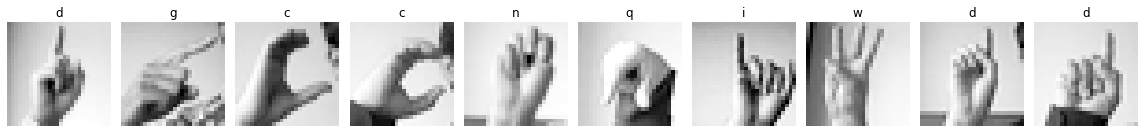

In [ ]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation.

In [ ]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  ### START CODE HERE

  #add another dimension to the data
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


  # Pass arguments to the flow method train data
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class and rescale
  validation_datagen = ImageDataGenerator(rescale = 1./255)
  
  # Pass arguments to the flow method validation data
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  return train_generator, validation_generator

In [ ]:
# Check generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

In [ ]:
def create_model():
  model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),                              
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')
        ])

  model.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])    
  
  return model

In [ ]:
# Save your model
model = create_model()
model.summary()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

Training history:

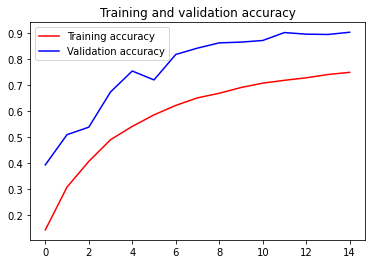

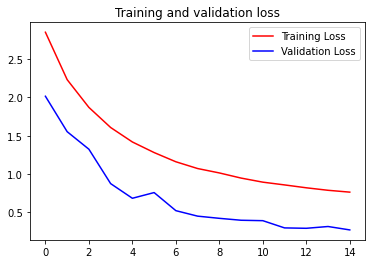

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()